In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [253]:
import numpy as np

from math import ceil



class noise(object):
    
    
    def __init__(self, traces, sampleRate, channNames, traceGain = 1.0, name = None, freqs = None, time = None, PSD = None \
                , real_PSD = None, imag_PSD = None, corrCoeff = None, unCorrNoise = None, corrNoise = None):
        self.traces = traces # 3d numpy array. dimention zero is number of traces, d-1 is channel number, 
        #d-3 is number of data points per trace
        self.sampleRate = sampleRate
        self.channNames = channNames
        self.time = time # array of x-values in units of time [sec]
        self.name = name
        
         #list of channel names
        self.traceGain = traceGain #convertion of trace amplitude from ADC bins to amperes 
        self.freqs = freqs
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        self.corrCoeff = corrCoeff
        self.unCorrNoise = unCorrNoise
        self.corrNoise = corrNoise
        
        
        
    
    def set_freqs(self, freqs):
        self.freqs = freqs
    def set_traceGain(self, traceGain):
        self.traceGain = traceGain
    def set_sampleRate(self, sampleRate):
        self.sampleRate = sampleRate
    def set_channNames(self, channNames):
        self.channNames = channNames
    def set_name(self, name):
        self.name = name
        
        
    
        
        
    def calculate_freqs(self):
        dt = 1/self.sampleRate
        self.freqs = np.fft.rfftfreq(self.traces.shape[2],d = dt)

    
    def caclulate_PSD(self): 
        # get shape of traces to use for iterating
        traceShape = self.traces.shape
        #check if length of individual trace is odd of even
        if traceShape[2] % 2 != 0:
            lenPSD = int((traceShape[2] + 1)/2)
        else:
            lenPSD = int(traceShape[2]/2 + 1)
            
        # initialize empty numpy array to hold the PSDs 
        PSD = np.empty(shape = (traceShape[1], lenPSD))
        real_PSD = np.empty(shape = (traceShape[1], lenPSD))
        imag_PSD = np.empty(shape = (traceShape[1], lenPSD))
               
        for ichan in range(traceShape[1]):

            fft = np.fft.rfft(self.traces[:,ichan,:])
            PSD_chan = np.abs(fft)**2
            real_PSD_chan = np.real(fft)**2
            imag_PSD_chan = np.imag(fft)**2
                
            # take the average of the PSD's for each trace, normalize, and fold over the 
            # negative frequencies since they are symmetric
            PSD[ichan] = np.mean(PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate) 
            real_PSD[ichan] = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
            imag_PSD[ichan] = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        
    def calculate_corrCoeff(self):
        nsizeMatrix = self.traces.shape[1]
        if self.traces.shape[2] % 2 != 0:
            lenPSD = int((self.traces.shape[2] + 1)/2)
        else:
            lenPSD = int(self.traces.shape[2]/2 + 1)
                
        nDataPoints = self.traces.shape[0]
                                
        #corr_coeff = np.zeros(shape=(nsizeMatrix,nsizeMatrix,lenPSD),dtype = np.float64)              
        traces_fft_chan = np.empty(shape = (nsizeMatrix,nDataPoints, lenPSD))        
        corr_coeff = np.empty(shape=(lenPSD,nsizeMatrix,nsizeMatrix)) 
        
        #for ichan in range(nsizeMatrix):       
        #    traces_fft_chan[ichan] = np.abs(np.fft.rfft(traces[:,ichan,:]))**2
        traces_fft_chan = np.abs(np.fft.rfft(traces))**2
        traces_fft_chan = np.swapaxes(traces_fft_chan, 0,1)
        for n in range(lenPSD):
            corr_coeff[n] = np.corrcoef(traces_fft_chan[:,:,n])
        
        self.corrCoeff = np.swapaxes(corr_coeff, 0, 2)
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    ############# plotting
    def plot_PSD(self, lgc_overlay = True, lgcSave = False, savePath = None):
        '''
        Function to plot the noise spectrum referenced to the TES line in units of Amperes/sqrt(Hz)
        
        Input parameters:
        lgc_overlay: boolian value. If True, PSD's for all channels are overlayed in a single plot, 
                     if False, each PSD for each channel is plotted in a seperate subplot
        lgcSave: boolian value. If True, the figure is saved in the user provided directory
        savePath: absolute path for the figure to be saved
        
        R
       
        
        '''
        
        
        
        if lgc_overlay:
            sns.set_context('notebook')
            plt.figure()
            plt.xlabel('frequency [Hz]')
            plt.ylabel('Input Referenced Noise [A/rtHz]')
            plt.grid(which = 'both')
            for ichan, channel in enumerate(self.channNames):
                plt.loglog(self.freqs[1:], self.PSD[ichan][1:], label = channel)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_overlay_plot.png')
                except:
                    print('Invalid save path. Figure not saved')
            
    
    
        if else:
            sns.set_context('poster', font_scale = 1.9)
            num_subplots = len(self.channNames)
            nRows = int(ceil(num_subplots/2))
            nColumns = 2

            fig, axes = plt.subplots(nRows, nColumns, figsize = (6*num_subplots,6*num_subplots)) 
            plt.suptitle(self.name,  fontsize=40)
            for ii in range(nRows*2):
                if ii < 4:
                    iRow = ii
                    jColumn = 0
                else:
                    iRow = ii - 4
                    jColumn = 1
                if ii < num_subplots:    
                    axes[iRow,jColumn].set_title(self.channNames[ii])
                    axes[iRow,jColumn].set_xlabel('frequency [Hz]')
                    axes[iRow,jColumn].set_ylabel('Input Referenced Noise [A/rtHz]')
                    axes[iRow,jColumn].grid(which = 'both')
                    axes[iRow,jColumn].loglog(self.freqs[1:], np.sqrt(self.PSD[ii][1:]))
                else:
                    axes[iRow,jColumn].axis('off')


            plt.tight_layout() 
            plt.subplots_adjust(top=0.95)
            plt.show()

            if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_subplot.png')
                except:
                    print('Invalid save path. Figure not saved')
            
        
            
######################### decorrelation of noise ##########
    #def Construct_crossPSD(self)

In [248]:
import math 
math.ceil(9/2)


5

### Load test traces

In [231]:
#with open('/nervascratch/cwfink/Analysis/Runs/SLAC/Run37/noise_traces_PT_on.pkl', 'wb') as f:
#    pkl.load(trace_on_cut, f)
import pickle as pkl    
with open('/nervascratch/cwfink/Analysis/Runs/SLAC/Run37/noise_traces_PT_on.pkl', "rb") as f:
        traces = pkl.load(f,fix_imports=True,encoding='latin1')

In [254]:
sampleRate = 625e3
channels = [ 'PCS1' , 'PES1' , 'PFS1' , 'PAS2' , 'PBS2' , 'PES2' , 'PDS2' ]
g124_noise = noise(traces, sampleRate, channels)


In [255]:
g124_noise.set_name('G124 SLAC Run 37 Pulse Tube On')
g124_noise.calculate_freqs()
g124_noise.caclulate_PSD()

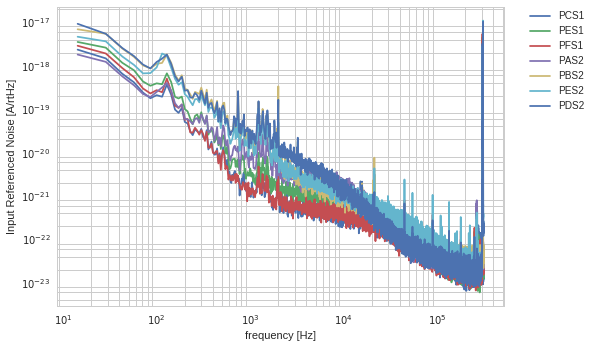

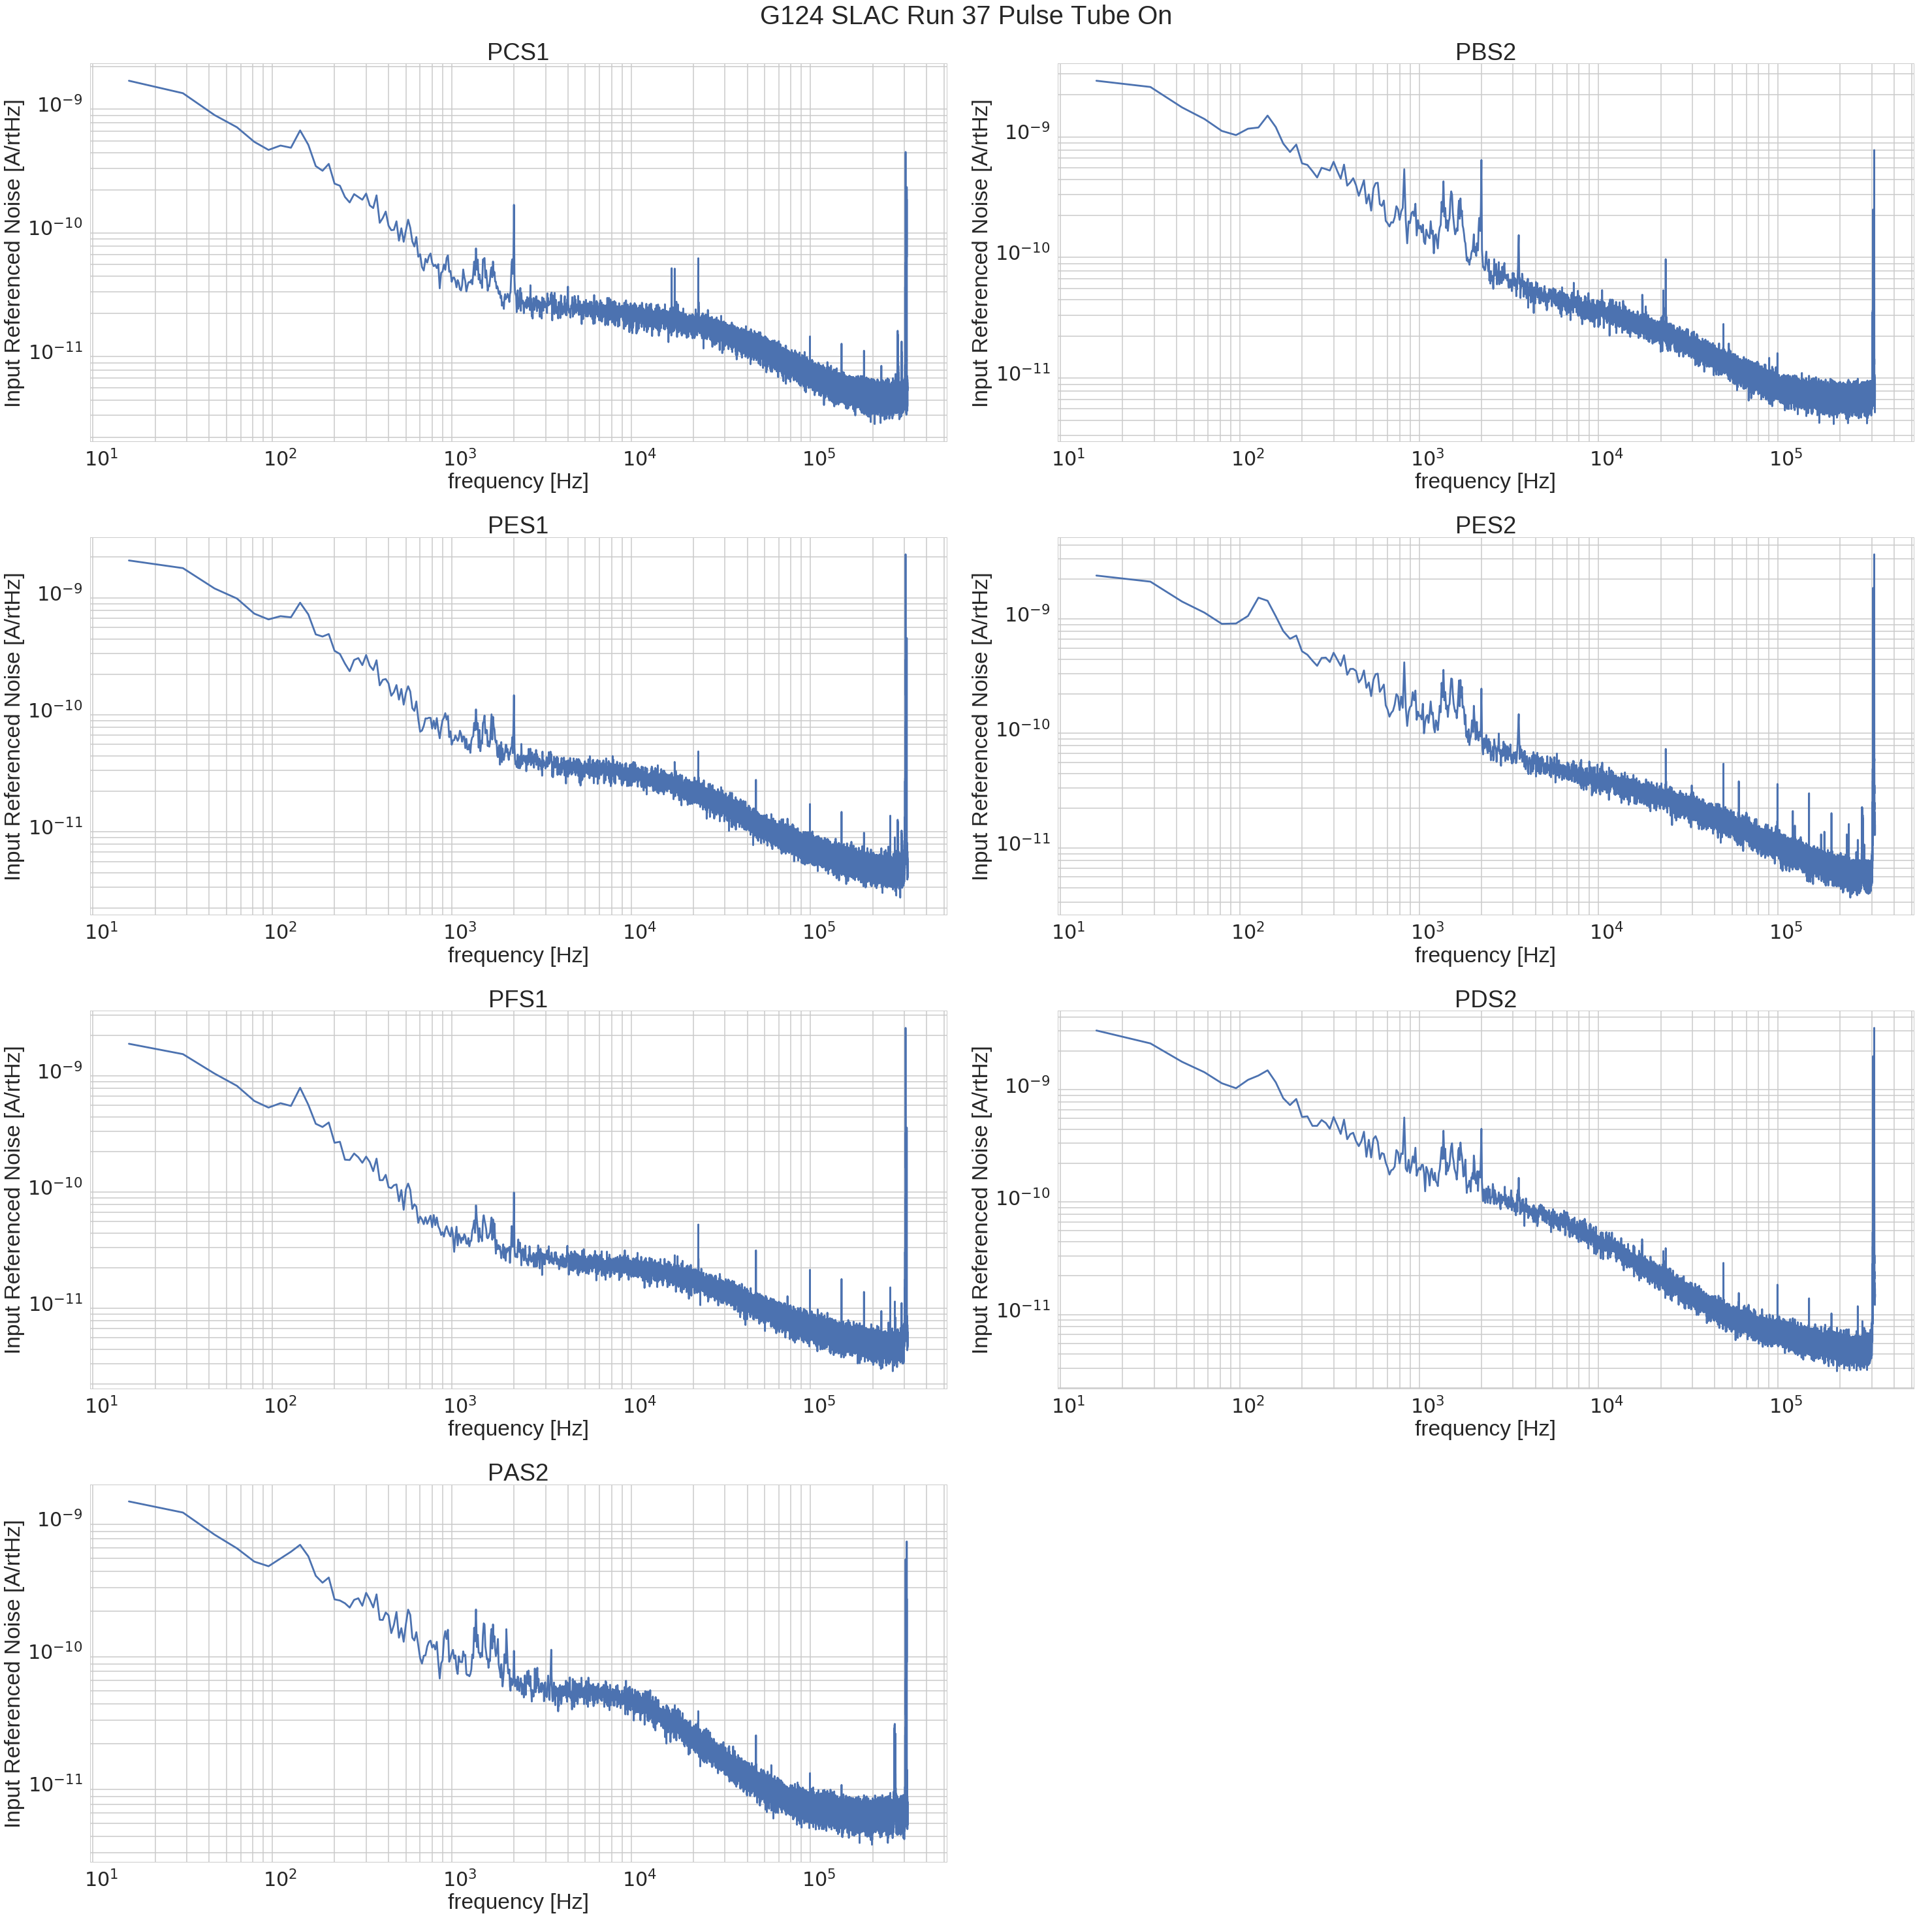

In [259]:
g124_noise.plot_PSD(lgc_overlay=True, lgc_subplot=True)

In [27]:
#%timeit g124_noise.calculate_corrCoeff()
g124_noise.calculate_corrCoeff()

In [23]:
%timeit g124_noise.calculate_corrCoeff()

1 loop, best of 3: 2.74 s per loop


In [11]:
g124_noise.traces.shape

(20, 7, 43750)

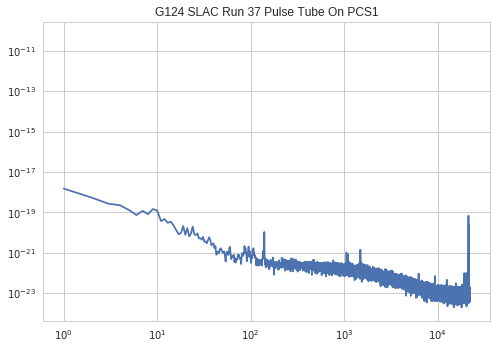

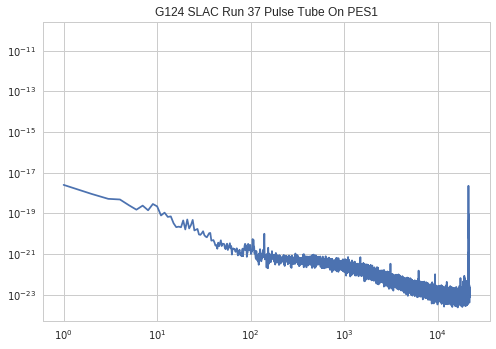

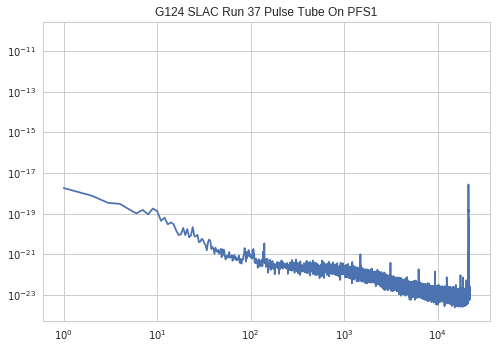

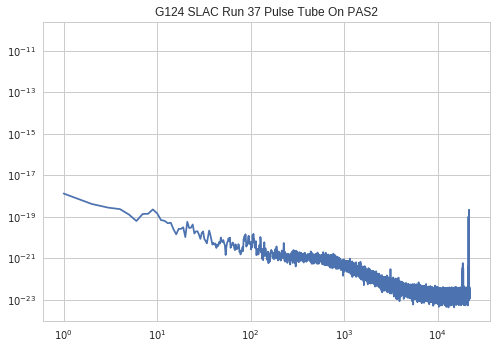

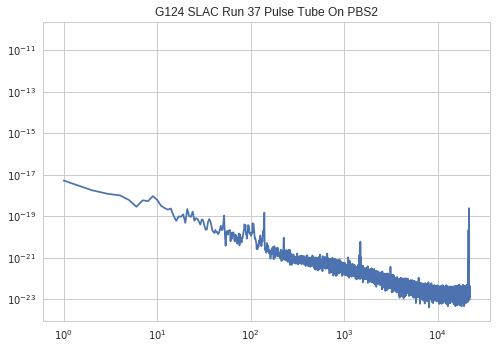

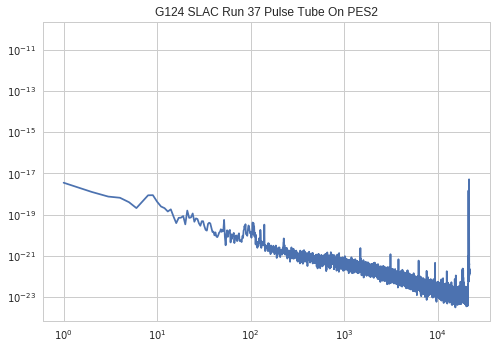

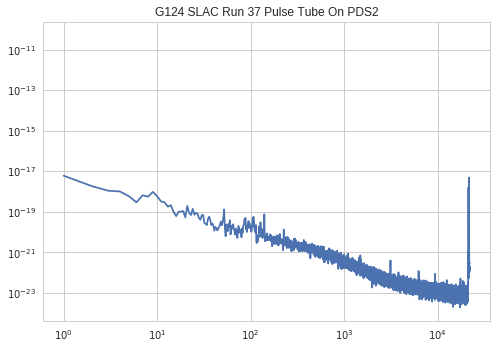

In [31]:



for ichan, PSD in enumerate(g124_noise.imag_PSD):
    plt.figure()
    plt.title(g124_noise.name + g124_noise.channNames[ichan])
    plt.loglog(PSD)

In [50]:
from scipy.signal import savgol_filter

from math import factorial
def savitzky_golay(y, window_size, order, deriv=0, rate=1):



     
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


def print_correlations(freq, CorrCoeff,titleStr, ds=1):
    
    
    nRow = len(CorrCoeff)
    nLen = len(CorrCoeff[0][0])
    
    
    
    title = 'Cross Channel Correlation: G124 SLAC Run 37 ' + titleStr
    plt.figure()
    plt.title(title)
    
    #freq_trunc = freqs#[:nLen/2]
    freq_trunc = freq#[:nLen/2]
    #print(freq)

    
    for iRow in range(nRow):
        for jColumn in range(nRow):
            
            if iRow > jColumn:
            
                label = 'Coeff_' + str(iRow) + str(jColumn)
                #print('x shape: {}'.format(freq_trunc.shape))
                #print('y shape: {}'.format(CorrCoeff[iRow][jColumn].shape))
            
                #plt.plot(freq_trunc, np.abs(corr_coeff[iRow][jColumn][:nLen/2]), label = label)
                #plt.plot(downsample(freq_trunc,ds), downsample(CorrCoeff[iRow][jColumn],ds), label = label)
                plt.plot(freq_trunc, savgol_filter(CorrCoeff[iRow][jColumn], 51,3), label = label, alpha = .2)
    #mean_rows = np.mean(CorrCoeff, axis = 0)
    #mean_columns = np.mean(mean_rows, axis = 0)
    #plt.plot(freq_trunc,mean_columns, label = 'mean')
    plt.legend(loc = 'best')
    #plt.grid()
    plt.xscale('log')
    #plt.ylim(0,1)
    #plt.xlim(10 , 3e5)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Correlation Factor')
    #plt.savefig(pathSave+ 'Figs/Corr_coeff_' + titleStr + '.png')
    plt.show()        
            

In [17]:
def downsample(arr, n):
    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

In [29]:
g124_noise.freqs

array([  0.00000000e+00,   1.42857143e+01,   2.85714286e+01, ...,
         3.12471429e+05,   3.12485714e+05,   3.12500000e+05])

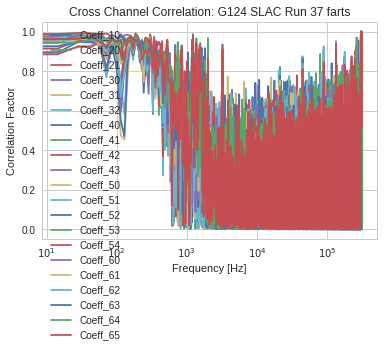

In [45]:
print_correlations(g124_noise.freqs, g124_noise.corrCoeff,titleStr = 'farts', ds=1)

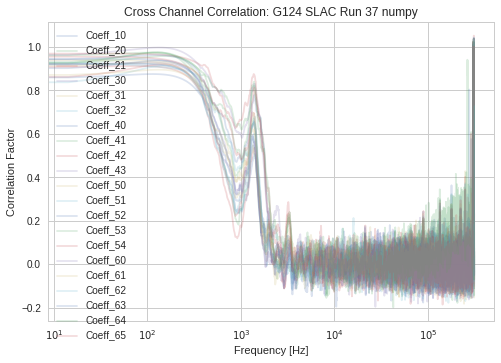

In [51]:
#g124_noise.freqs
print_correlations(g124_noise.freqs, g124_noise.corrCoeff,titleStr = 'numpy', ds=1)

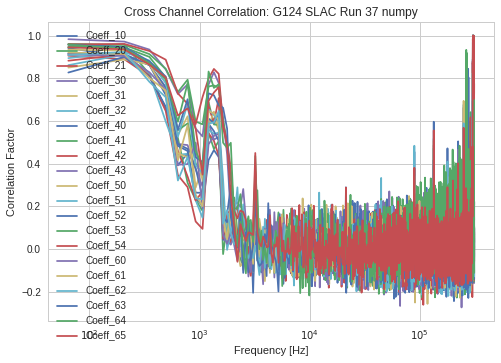

In [44]:
print_correlations(g124_noise.freqs, g124_noise.corrCoeff,titleStr = 'numpy', ds=10)